# Mental Health Conversations - Exploratory Data Analysis

This notebook explores:
- Dataset characteristics and quality
- Text patterns in patient messages and therapist responses
- Response type distributions
- Next steps for ML pipeline

Dataset: Conversations between users and experienced psychologists

In [134]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

print("Libraries imported!")

Libraries imported!


## 1. Data Loading and Initial Exploration

In [135]:
# Load the dataset
df = pd.read_csv('../data/train.csv').astype(str)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nHead:")
df.head()

Dataset shape: (3512, 2)
Columns: ['Context', 'Response']

Head:


,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [136]:
# Basic dataset information
print("Dataset Info")
df.info()

print("\nMissing Values")
missing_data = df.isnull().sum()
print(missing_data)

print("\nBasic Statistics")
print(f"Total rows: {len(df):,}")
print(f"Missing Context: {df['Context'].isnull().sum()}")
print(f"Missing Response: {df['Response'].isnull().sum()}")
print(f"Empty Context: {(df['Context'].str.strip() == '').sum()}")
print(f"Empty Response: {(df['Response'].str.strip() == '').sum()}")
print(f"Duplicate contexts: {df.duplicated().sum()} duplicates")


Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Context   3512 non-null   object
 1   Response  3512 non-null   object
dtypes: object(2)
memory usage: 55.0+ KB

Missing Values
Context     0
Response    0
dtype: int64

Basic Statistics
Total rows: 3,512
Missing Context: 0
Missing Response: 0
Empty Context: 0
Empty Response: 0
Duplicate contexts: 760 duplicates


In [ ]:
# Check  duplicate rows
duplicates = df[df.duplicated(keep=False)]

print(f"Total duplicate rows: {len(duplicates)}")

if not duplicates.empty:
    display(duplicates.head(10))  # Show first 10 duplicates
else:
    print("✅ No duplicate rows found.")

Total duplicate rows: 1501


,Context,Response
23,I have so many issues to address. I have a his...,Let me start by saying there are never too man...
24,I have so many issues to address. I have a his...,It is never too late to get help and begin mak...
25,I have so many issues to address. I have a his...,You have been through so much and it sounds li...
26,I have so many issues to address. I have a his...,Absolutely not. I strongly recommending worki...
27,I have so many issues to address. I have a his...,"Absolutely not! In fact, most people have man..."
28,I have so many issues to address. I have a his...,This is a great question! I personally don't b...
29,I have so many issues to address. I have a his...,Hi! Many people begin their therapeutic journe...
30,I have so many issues to address. I have a his...,Absolutely not. It sounds like you have signif...
31,I have so many issues to address. I have a his...,Most clients have many issues that need workin...
32,I have so many issues to address. I have a his...,Just go! You start with the most prevalent iss...


## 2. Text Length Analysis

In [138]:
# Add text length features
df['context_words'] = df['Context'].str.split().str.len()
df['response_words'] = df['Response'].str.split().str.len()

# Text length statistics
print(f"\nWord Count Statistics:")
print(f"\nContext words: \n{df['context_words'].describe()}")
print(f"\nResponse words: \n{df['response_words'].describe()}")


Word Count Statistics:

Context words: 
count    3512.000000
mean       55.180809
std        48.275077
min         5.000000
25%        28.000000
50%        46.000000
75%        68.000000
max       526.000000
Name: context_words, dtype: float64

Response words: 
count    3512.000000
mean      177.003132
std       120.743207
min         1.000000
25%        93.000000
50%       144.000000
75%       221.000000
max       939.000000
Name: response_words, dtype: float64


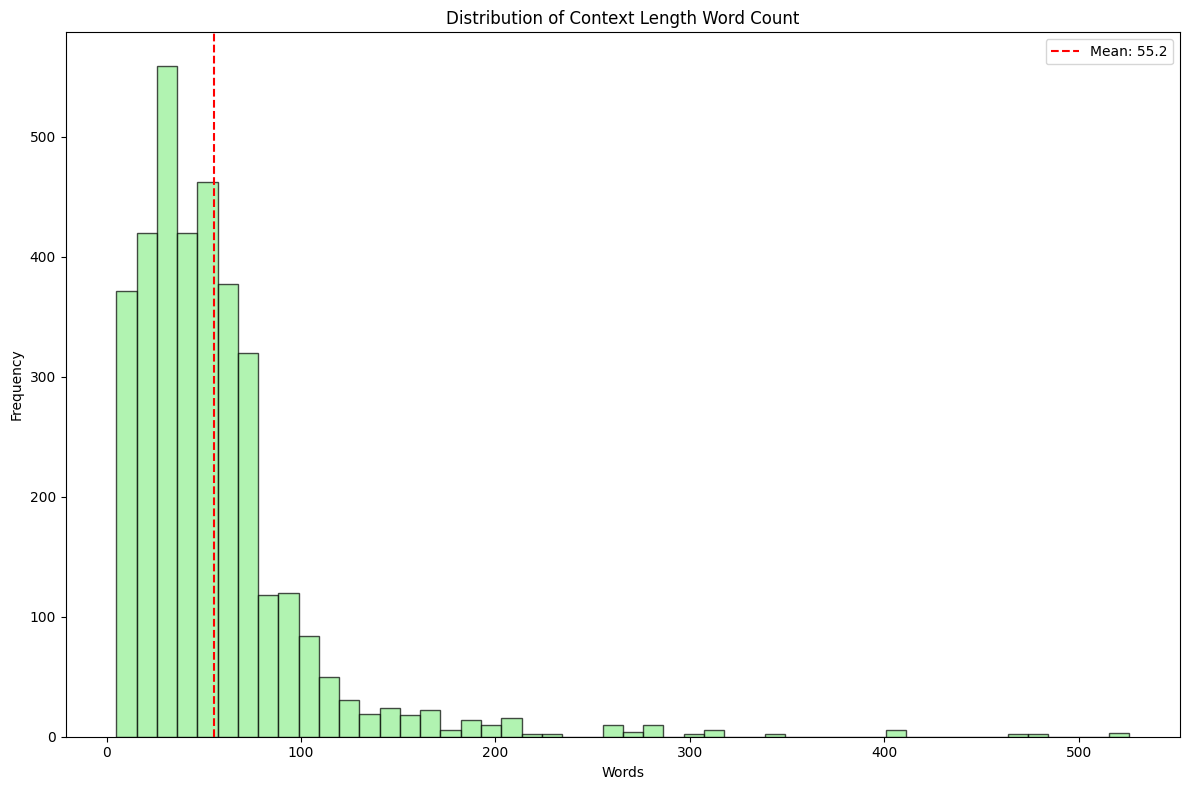

In [139]:
#Visualize context word count
plt.figure()
plt.hist(df['context_words'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Context Length Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.axvline(df['context_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["context_words"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

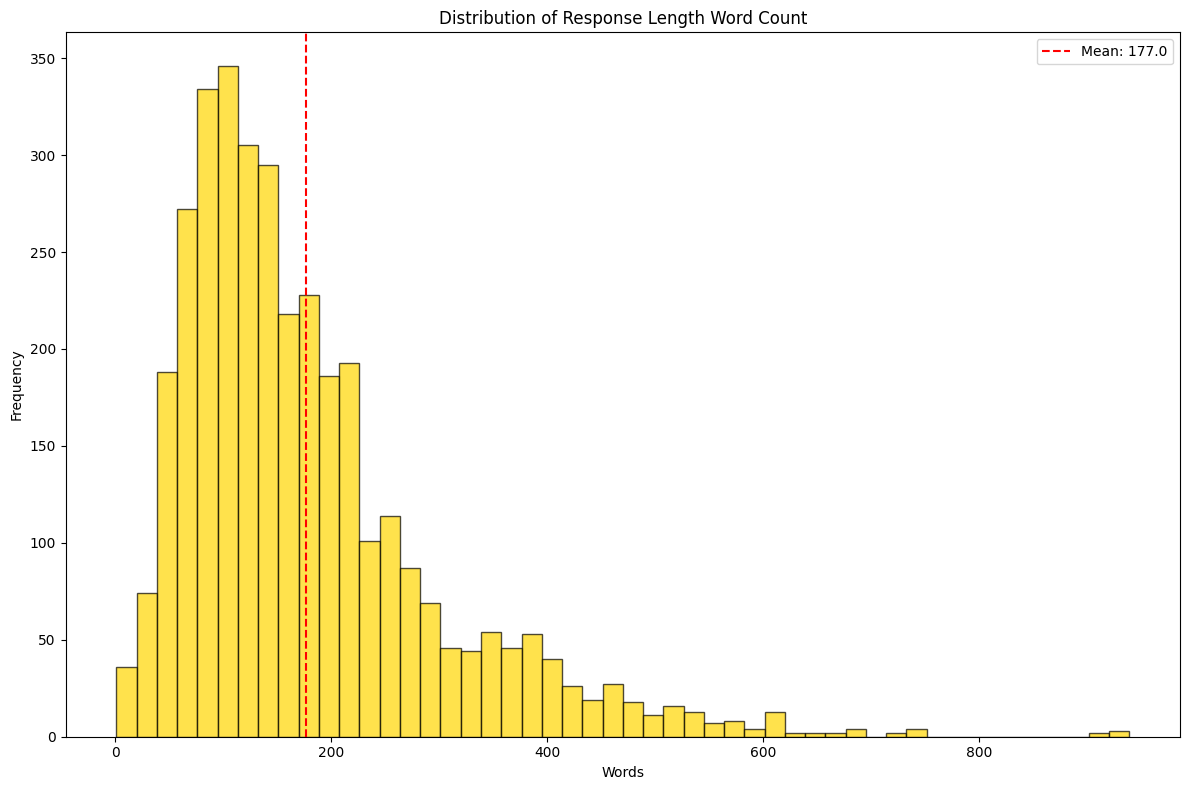

In [140]:
# Visualize response word count 
plt.figure()
plt.hist(df['response_words'], bins=50, alpha=0.7, color='gold', edgecolor='black')
plt.title('Distribution of Response Length Word Count')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.axvline(df['response_words'].mean(), color='red', linestyle='--', label=f'Mean: {df["response_words"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()


## 3. Word Analysis

In [141]:
# Function to get most common words
def get_top_words(texts, n=15, min_length=3):
    """Get most common words from a series of texts"""
    # Combine all texts
    all_text = ' '.join(texts.astype(str)).lower()
    
    # Remove punctuation and extract words
    words = re.findall(r'\b\w+\b', all_text)
    
    # Filter by length and common stop words
    stop_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those', 'me', 'you', 'he', 'she', 'it', 'we', 'they', 'him', 'her', 'us', 'them', 'my', 'your', 'his', 'hers', 'its', 'our', 'their'}
    
    filtered_words = [word for word in words if len(word) >= min_length and word not in stop_words]
    
    # Count and return top words
    word_counts = Counter(filtered_words)
    return word_counts.most_common(n)

# Get top words for contexts and responses
top_context_words = get_top_words(df['Context'])
top_response_words = get_top_words(df['Response'])

print("Most Common Words in Context")
for word, count in top_context_words:
    print(f"{word}: {count:,}")

print("\nMost Common Words in Responses")
for word, count in top_response_words:
    print(f"{word}: {count:,}")

Most Common Words in Context
how: 1,272
feel: 1,223
don: 1,177
about: 1,166
like: 1,152
not: 1,002
know: 974
what: 965
get: 901
just: 897
out: 874
want: 768
because: 767
when: 762
years: 661

Most Common Words in Responses
what: 4,564
not: 4,198
about: 3,792
feel: 2,730
there: 2,591
help: 2,344
like: 2,274
yourself: 2,217
when: 2,206
how: 2,158
more: 2,154
from: 2,133
some: 2,114
relationship: 2,026
who: 1,996


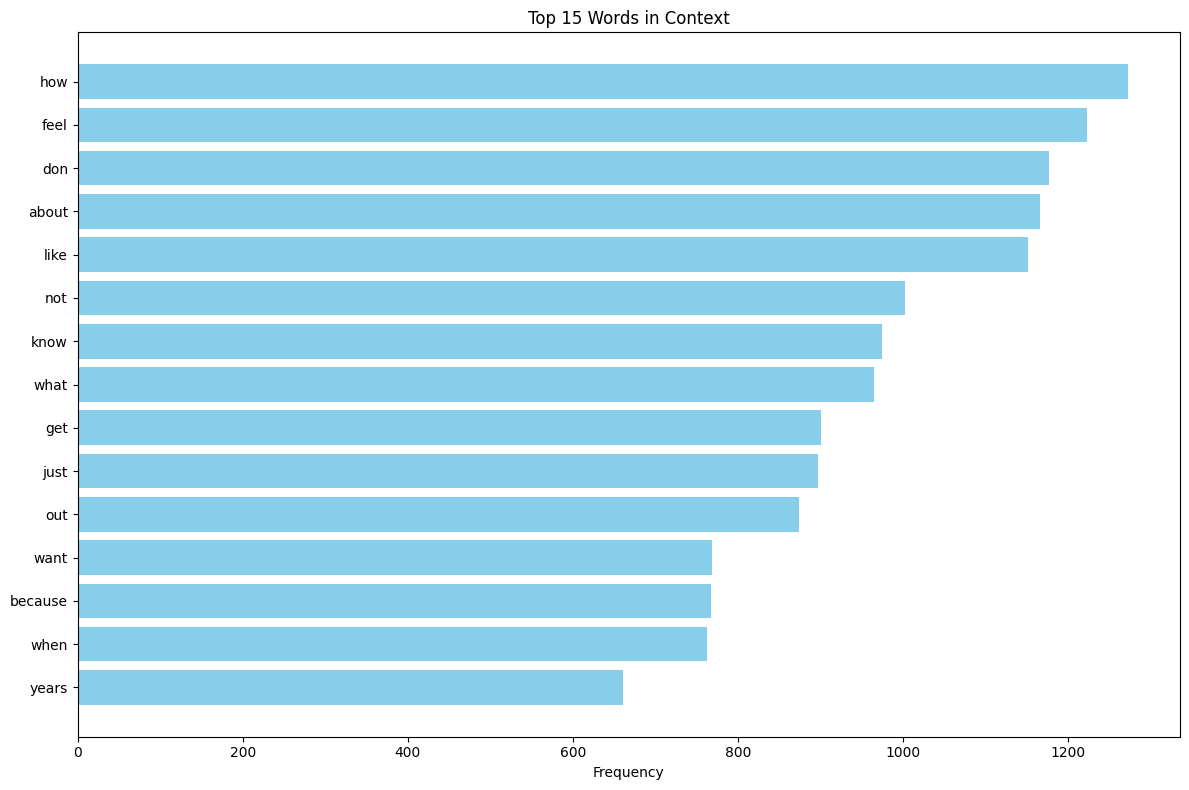

In [142]:
# Visualize top words in context
context_words, context_counts = zip(*top_context_words[:15])

plt.figure()
plt.barh(range(len(context_words)), context_counts, color='skyblue')
plt.yticks(range(len(context_words)), context_words)
plt.xlabel('Frequency')
plt.title('Top 15 Words in Context')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

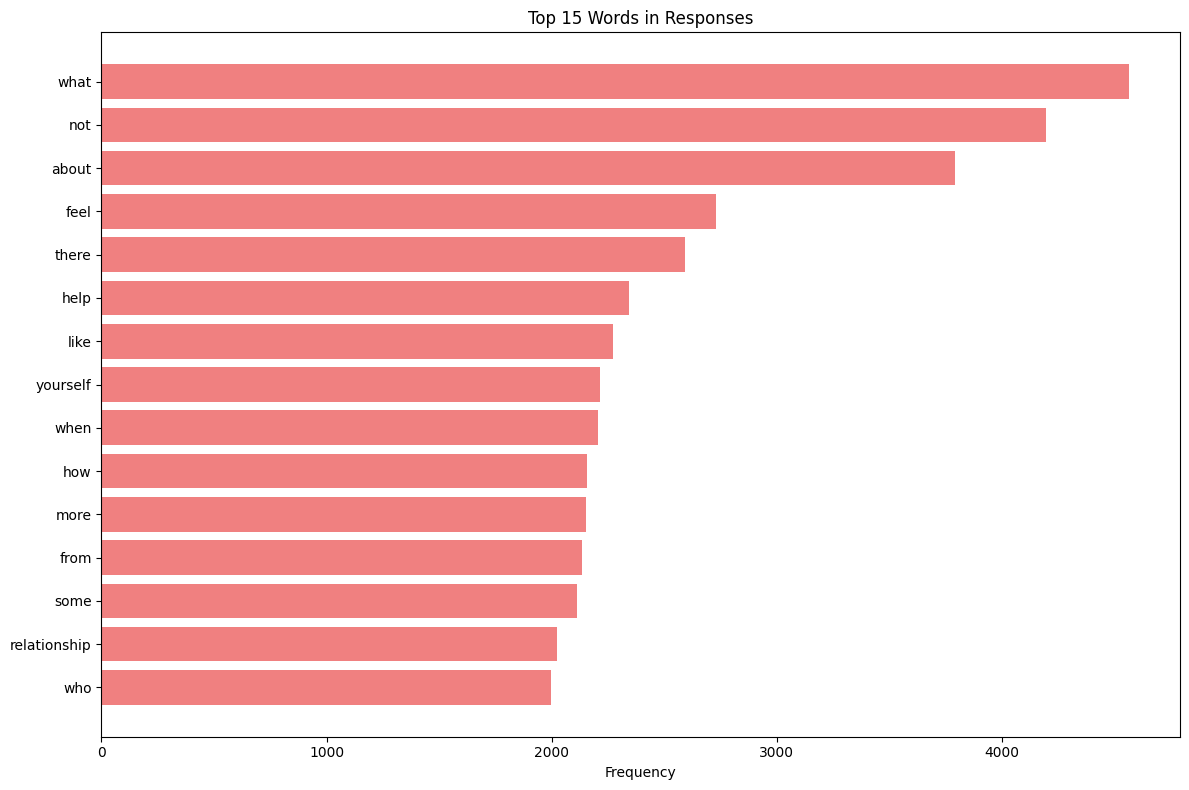

In [143]:
# Visualize top words in responses
response_words, response_counts = zip(*top_response_words[:15])

plt.figure()
plt.barh(range(len(response_words)), response_counts, color='lightcoral')
plt.yticks(range(len(response_words)), response_words)
plt.xlabel('Frequency')
plt.title('Top 15 Words in Responses')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 5. Summary and Next Steps

In [144]:
print("\nNext steps:")
print("1. Clean and preprocess the data")
print("2. Create train/validation/test splits")
print("3. Tokenize text")
print("4. Train LLM locally")
print("5. Evaluate model performance")
print("7. Send model data to front end")


Next steps:
1. Clean and preprocess the data
2. Create train/validation/test splits
3. Tokenize text
4. Train LLM locally
5. Evaluate model performance
7. Send model data to front end
